In [731]:
import pandas

data = pandas.read_csv('data/five.csv').drop(columns='date')
numbers = data[['num.1','num.2','num.3','num.4','num.5']]
# data = data[data.year > 1997]

In [732]:
# it would be nice to continue the scatter pattern somehow

# plan1: make a GAN - wth was i doing?
#   input: year + week
#   output: 90 long vector each item between 0 and 1 with a sum of 5 hopefully
# and see what happens
# training + test data: parse winning numbers into this 90 long vector

# plan2: make a GAN to generate a pattern
#   input: ?? lottery numbers (previous week?) aka. latent_dimension = 90
#       noise: 5 random -> create sparse binary vector with arrangement like (15,30,45,60,75) +- (weight * noise[0:5])
#   output: some kind of pattern eg N vector each 90 long with 0s and (hopefully 5) 1s 

In [733]:
import random
import torch

# seed = 123
# random.seed(seed)
# torch.manual_seed(seed)

In [734]:
# create a custom dataset
import numpy
from torch.utils.data import Dataset

class LotteryNumbers(Dataset):
    def __init__(self, df, slice_len):
        self.df = df
        self.len = slice_len

    def __len__(self):
        return len(self.df)-self.len

    def __getitem__(self, idx):
        nums = self.df.iloc[idx:idx+self.len] - 1
        result = torch.zeros(self.len, 90)
        for row in nums.iterrows():
            result[row[0]-idx][row[1]] = 1
        return (idx,result)

def parse_tensor(t):
    return list(numpy.where(t == 1)[0] + 1)


In [735]:
latent_dimensions = 90

gen_feature_map_size = 64
disc_feature_map_size = 64

epoch_count = 5

learning_rate = 0.0002
beta1 = 0.5

# batch_size = 1
workers = 4

data_slice_lenght = 120

In [736]:
from torch.utils.data import DataLoader

dataset = LotteryNumbers(numbers, data_slice_lenght)
dataloader = DataLoader(dataset, shuffle=True, num_workers=workers)
device = torch.device('cpu')

criterion = nn.BCELoss()

def noisy_lottery_numbers(count = 5, limit = 90):
    noise = torch.randn(count, device=device)
    noise = noise / max(abs(noise))
    return [int(n) for n in (noise / 2 + 0.5) * (limit-1)]

def lottery_to_tensor(nums):
    result = torch.zeros(1,90,1)
    result[0][nums] = torch.tensor([1.])
    return result

def print_tensor(t):
    print(t.shape, t.squeeze())


noise_gen = lambda: lottery_to_tensor(noisy_lottery_numbers())

fixed_noise = noise_gen()
print(parse_tensor(fixed_noise.squeeze()))
print_tensor(fixed_noise)

fake_label = 0
real_label = 1

# for i in range(30):
#     plot_batch(*next(iter(dataloader)))

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


[20, 33, 72, 86, 90]
torch.Size([1, 90, 1]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])


In [737]:
from torch import nn, optim

kernels = 8

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose1d(latent_dimensions, gen_feature_map_size * 4, kernel_size=kernels, stride=1, padding=0, dilation=1, bias=False),
            nn.BatchNorm1d(gen_feature_map_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(gen_feature_map_size * 4, gen_feature_map_size * 2, kernel_size=kernels, stride=2, padding=1, dilation=1, bias=False),
            nn.BatchNorm1d(gen_feature_map_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose1d(gen_feature_map_size * 2, gen_feature_map_size, kernel_size=kernels, stride=2, padding=1, dilation=1, bias=False),
            nn.BatchNorm1d(gen_feature_map_size),
            nn.ReLU(True),

            nn.ConvTranspose1d(gen_feature_map_size, data_slice_lenght, kernel_size=kernels, stride=2, padding=2, dilation=1, bias=False),
            # nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

gen_network = Generator().to(device)
gen_network.apply(weights_init)

gen_optimizer = optim.Adam(gen_network.parameters(), lr=learning_rate, betas=(beta1, 0.999))

gen_network

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(90, 256, kernel_size=(8,), stride=(1,), bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose1d(256, 128, kernel_size=(8,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose1d(128, 64, kernel_size=(8,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose1d(64, 120, kernel_size=(8,), stride=(2,), padding=(2,), bias=False)
  )
)

In [738]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(data_slice_lenght, disc_feature_map_size, kernel_size=kernels, stride=2, padding=1, dilation=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(disc_feature_map_size, disc_feature_map_size * 2, kernel_size=kernels, stride=2, padding=1, dilation=1, bias=False),
            nn.BatchNorm1d(disc_feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(disc_feature_map_size * 2, disc_feature_map_size * 4, kernel_size=kernels, stride=2, padding=1, dilation=1, bias=False),
            nn.BatchNorm1d(disc_feature_map_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(disc_feature_map_size * 4, 1, kernel_size=kernels, stride=2, padding=1, dilation=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

disc_network = Discriminator().to(device)
disc_network.apply(weights_init)

disc_optimizer = optim.Adam(disc_network.parameters(), lr=learning_rate, betas=(beta1, 0.999))

disc_network

Discriminator(
  (main): Sequential(
    (0): Conv1d(120, 64, kernel_size=(8,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(64, 128, kernel_size=(8,), stride=(2,), padding=(1,), bias=False)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv1d(128, 256, kernel_size=(8,), stride=(2,), padding=(1,), bias=False)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv1d(256, 1, kernel_size=(8,), stride=(2,), padding=(1,), bias=False)
    (9): Sigmoid()
  )
)

In [739]:
# training

they_grow_up_so_fast = []
gen_losses = []
disc_losses = []

iters = 0

print('Start training')
epoch_count = 1
for epoch in range(1,epoch_count+1):
    for i, data in enumerate(dataloader, 0):
        data_idx, data_vectors = data
        # print(data_idx, data_vectors.shape, data_vectors)
        disc_network.zero_grad()
        disc_output = disc_network(data_vectors)
        # print(disc_output.shape, disc_output)
        label = torch.full(tuple(disc_output.size()), real_label, dtype=torch.float, device=device)
        # print(label.shape, label)
        disc_err_real = criterion(disc_output, label)
        disc_err_real.backward()
        D_x = disc_output.item()

        noise = noise_gen()
        fake = gen_network(noise)
        # print(fake.shape, fake)
        disc_output = disc_network(fake.detach())        
        # print(disc_output.shape, disc_output)
        label.fill_(fake_label)
        disc_err_fake = criterion(disc_output, label)
        disc_err_fake.backward()
        D_G_z1 = disc_output.item()
        
        disc_err = disc_err_real + disc_err_fake
        disc_optimizer.step()

        gen_network.zero_grad()
        label.fill_(real_label)
        disc_output = disc_network(fake)
        gen_err = criterion(disc_output, label)
        gen_err.backward()
        D_G_z2 = disc_output.item()

        gen_optimizer.step()

        if i % 50 == 0:
            print(f'[{epoch}/{epoch_count}][{i}/{len(dataloader)}]',
                  f'Losses: D={disc_err:.4f}, G={gen_err:.4f}',
                  f'D(x)={D_x:.4f}, D(G(z))={D_G_z1:.2f}/{D_G_z2:.2f}',
                sep='\t')

        # Save Losses for plotting later
        gen_losses.append(gen_err.item())
        disc_losses.append(disc_err.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epoch_count) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen_network(fixed_noise).detach().cpu()
            they_grow_up_so_fast.append(fake)

        iters += 1
print('Training ended')

Start training
[1/1][0/3230]	Losses: D=1.3716, G=3.5395	D(x)=0.4409, D(G(z))=0.42/0.03
[1/1][50/3230]	Losses: D=2.3044, G=2.7513	D(x)=0.2733, D(G(z))=0.63/0.06
[1/1][100/3230]	Losses: D=1.8083, G=3.3430	D(x)=0.4744, D(G(z))=0.65/0.04
[1/1][150/3230]	Losses: D=2.6754, G=2.8812	D(x)=0.3719, D(G(z))=0.81/0.06
[1/1][200/3230]	Losses: D=0.9216, G=3.0293	D(x)=0.7018, D(G(z))=0.43/0.05
[1/1][250/3230]	Losses: D=1.3621, G=3.0565	D(x)=0.6427, D(G(z))=0.60/0.05
[1/1][300/3230]	Losses: D=1.2011, G=2.7117	D(x)=0.5029, D(G(z))=0.40/0.07
[1/1][350/3230]	Losses: D=0.6022, G=2.7274	D(x)=0.7103, D(G(z))=0.23/0.07
[1/1][400/3230]	Losses: D=1.3384, G=2.6957	D(x)=0.3901, D(G(z))=0.33/0.07
[1/1][450/3230]	Losses: D=1.5120, G=2.9165	D(x)=0.3673, D(G(z))=0.40/0.05
[1/1][500/3230]	Losses: D=1.6476, G=3.0348	D(x)=0.3785, D(G(z))=0.49/0.05
[1/1][550/3230]	Losses: D=3.1469, G=2.9501	D(x)=0.0920, D(G(z))=0.53/0.05
[1/1][600/3230]	Losses: D=1.2319, G=2.8361	D(x)=0.3708, D(G(z))=0.21/0.06
[1/1][650/3230]	Losses: D=

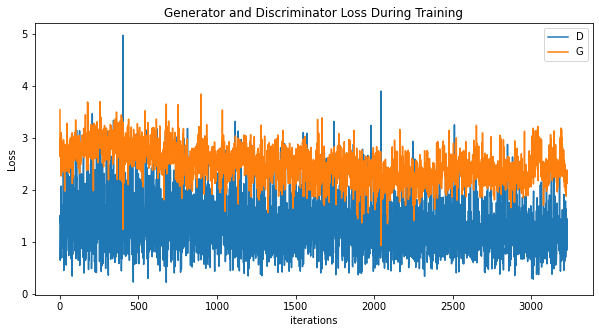

In [740]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(disc_losses,label="D")
plt.plot(gen_losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

[3.2416666666666667, 4.233333333333333, 4.083333333333333, 3.7, 3.816666666666667, 4.75, 4.116666666666666, 3.95]
[[37, 44, 61, 76, 77, 81, 84],
 [78],
 [23, 33, 39, 71, 79, 81],
 [9, 36, 57, 60, 65, 68, 74],
 [23, 39, 71],
 [75, 83],
 [80, 84],
 [25, 85],
 [11, 13, 15, 38, 39, 41, 53, 63, 71, 83, 85],
 [9, 14, 24, 32, 33, 61, 67, 69, 72, 77, 85],
 [15, 23, 24, 32, 56, 74],
 [21, 42, 53, 58, 66, 82],
 [7, 22, 53, 57, 70, 78],
 [9, 88],
 [78],
 [11, 14, 18, 19, 38, 43, 46, 50, 51, 62, 70, 80, 84],
 [21, 42, 53, 86],
 [24, 43, 73],
 [10, 59, 86, 88],
 [15, 26, 71],
 [14, 35, 75],
 [12, 16, 42, 60, 81],
 [79],
 [5, 13, 18, 21],
 [6, 11, 27, 40, 51, 59, 78],
 [31, 63],
 [76, 87],
 [12, 81, 86],
 [22, 38, 46, 78],
 [13, 76],
 [44],
 [18, 24, 40, 47, 56, 58, 72, 83],
 [38, 79],
 [20, 47],
 [86],
 [4, 11, 43],
 [36, 54, 62, 76],
 [87],
 [87],
 [80],
 [41, 81],
 [10, 57, 58, 69, 77, 83, 84],
 [84],
 [37, 78],
 [16, 80, 81, 88],
 [84],
 [80],
 [24, 36, 40, 44, 68, 69, 78],
 [33, 35, 41, 50, 67,

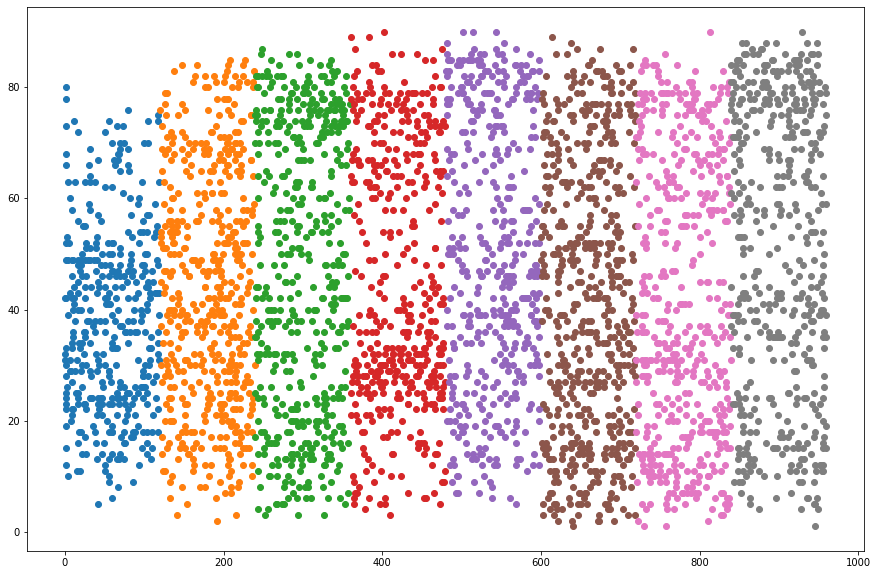

In [765]:
# test_batch_idxs, test_batch = next(iter(dataloader))
def plot_batch(test_batch_idxs, test_batch, parser=parse_tensor):
    from matplotlib import pyplot
    xx,yy = ([],[])
    for idx, batch in zip(test_batch_idxs, test_batch):
        batch = [(int(idx)+subidx, parser(mx)) for subidx, mx in zip(range(len(batch)), batch)]
        batch = [(id,n) for id, ns in batch for n in ns]
        xxx,yyy = zip(*batch)
        xx.append(xxx)
        yy.append(yyy)
    pyplot.rcParams['figure.figsize'] = (15,10)
    pyplot.scatter(xx,yy)

avgs = []

for fakeId, batch in zip(range(len(they_grow_up_so_fast)),they_grow_up_so_fast):
    limiter = lambda l: lambda t: list(numpy.where(abs(t) > l)[0] + 1)
    limiter = limiter(0.8)
    norm_batch = [abs(nvec)/max(abs(nvec)) for nvec in batch[0]]
    nums_batch = [limiter(n) for n in norm_batch]
    num_of = [len(n) for n in nums_batch]
    avgs.append(sum(num_of)/len(num_of))
    # for n in norm_batch:
    #     print(len(limiter(n)))
    # break
    plot_batch([fakeId*len(batch[0])], [norm_batch], limiter)
from pprint import pprint
print(avgs)
pprint(nums_batch)
    

In [775]:
# abs(base)/max(abs(base))
base
state = gen_network.state_dict()
copy = Generator()
copy.load_state_dict(state_dict=state)

base = gen_network(fixed_noise)[0][0]
base2 = copy(fixed_noise)[0][0]
base, base2

(tensor([-0.0446,  0.1113,  0.1263,  0.2128,  0.3531,  0.3386,  0.1471,  0.0343,
         -0.0307,  0.4018, -0.4248,  0.4110,  0.0793,  0.4481, -0.4142, -0.3040,
         -0.2544,  0.1971, -0.3053,  0.3910,  0.2261,  0.1340, -0.3510, -0.2359,
          0.0431,  0.0285, -0.0165,  0.3824,  0.3982,  0.3226, -0.4927, -0.2502,
          0.1114,  0.2319, -0.2562,  0.4803,  0.7164,  0.1565, -0.1340, -0.2962,
          0.0257,  0.2012, -0.3052,  0.6714,  0.3790,  0.2253, -0.2207, -0.2011,
         -0.0014,  0.4977, -0.0821,  0.4396,  0.1758,  0.2387, -0.4432, -0.1801,
         -0.0822,  0.2829, -0.2306,  0.2872,  0.6090,  0.3303, -0.2408, -0.0833,
         -0.0796,  0.2376, -0.3829,  0.2734,  0.5282,  0.2705, -0.2733, -0.2234,
          0.0077, -0.3307,  0.0510,  0.6060,  0.6820,  0.2779,  0.0161, -0.3307,
          0.5871, -0.1660,  0.1834,  0.6204,  0.3548, -0.0844, -0.1871,  0.2506,
          0.0166,  0.3579], grad_fn=<SelectBackward>),
 tensor([-0.0446,  0.1113,  0.1263,  0.2128,  0.3531, 